In [1]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [20]:
metadata = pd.read_csv("HAM10000_metadata.csv")
print(len(metadata))

10015


In [21]:
print(metadata.head(5))

     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


In [22]:
labels = list(metadata.dx.unique())
print(labels)

['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec']


nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64


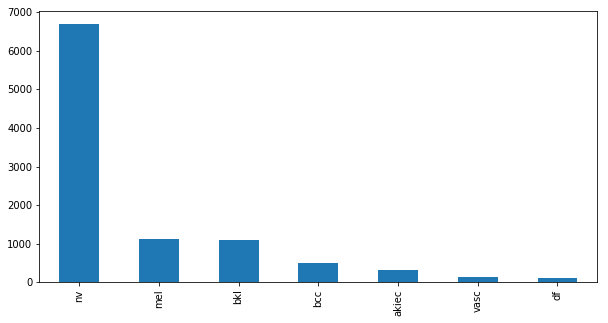

In [23]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
counts = metadata["dx"].value_counts()
print(counts)
counts.plot(kind='bar', ax=ax1)
#metadata["dx"].hist()

In [19]:
# parse out all classes to individual dataframes
nv = metadata[metadata["dx"] == "nv"]
mel = metadata[metadata["dx"] == "mel"]
bkl = metadata[metadata["dx"] == "bkl"]
bcc = metadata[metadata["dx"] == "bcc"]
akiec = metadata[metadata["dx"] == "akiec"]
vasc = metadata[metadata["dx"] == "vasc"]
df = metadata[metadata["dx"] == "df"]

pandas.core.frame.DataFrame

In [ ]:
def display(image):
    fig = plt.figure(figsize=(9, 7))
    #plt.imshow(image, cmap="gray")
    plt.imshow(image)
    plt.axis("off")
    plt.show()

In [ ]:
image = cv2.imread("HAM10000_images_part_1/ISIC_0024340.jpg")

#image = cv2.imread("HAM10000_images_part_1/ISIC_0024457.jpg")
# RGB
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
R, G, B = cv2.split(rgb_image)

# HSV
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
H, S, V = cv2.split(hsv_image)

_V = cv2.equalizeHist(V)

_hsv = cv2.merge([H, S, _V])

_new_rgb = cv2.cvtColor(_hsv, cv2.COLOR_HSV2RGB)

In [ ]:
i = rgb_image
# now let's extract some features from the image
low = np.min(i)
high = np.max(i)
mean = np.mean(i)
std = np.std(i)
variance = np.var(i)
# print
print("Min: {}".format(low))
print("Max: {}".format(high))
print("Mean: {}".format(mean))
print("Standard Deviation: {}".format(std))
print("Variance: {}".format(variance))

In [ ]:
#display(hsv_image)
display(rgb_image)
display(_new_rgb)
#display(gaussian)